# Example: Data-Driven Minimum-Variance Portfolio Allocation for Risky and Risk-Free Assets
The Minimum-Variance (Markowitz) portfolio allocation problem for a portfolio composed of both risk-free and risky assets $\mathcal{P}$ minimizes the variance of the portfolio $\sigma_{\mathcal{P}}^2$ subject to a minimal required return and non-negativity constraints: 
\begin{eqnarray*}
\text{minimize}~\sigma_{\mathcal{P}}^2 &=& \sum_{i\in\mathcal{P}}\sum_{j\in\mathcal{P}}\omega_{i}\omega_{j}
\text{cov}\left(r_{i},r_{j}\right) \\
\text{subject to}~\mathbb{E}(r_{\mathcal{P}})& = & \left(\omega_{f}r_{f}+\sum_{i\in\mathcal{P}}\omega_{i}\cdot\mathbb{E}(r_{i})\right)\geq{R^{*}}\\
\omega_{f}+\sum_{i\in\mathcal{P}}\omega_{i} & = & 1 \\
\text{and}~\omega_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray*}
The terms $\omega_{i}\geq{0}$ denote the dollar fraction of risky asset $i\in\mathcal{P}$, $\omega_{f}$ denotes the dollar fraction allocated to the risk-free assets in the portfolio, $r_{f}$ represents the annual risk-free rate of return, and $R^{*}$ is the minimum annual required rate of return 
for the overall portfolio $\mathcal{P}$. 

### Learning objectives
In this example, we'll compute the [Efficient Frontier](https://en.wikipedia.org/wiki/Efficient_frontier) and the capital allocation line (CAL) for a portfolio comprised of a combination of risk-free and risky assets. The expected return and the covariance of the returns are calculated from a historical dataset. 

* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-29-2023`. We'll also compute the analyzed expected returns, covariance, and correlation arrays from this historical dataset and explore these values. 
* __Task 1__: Compute the efficient frontier by solving the optimization problem described above: minimize the risk for a specified minimum reward value, visualize the efficient frontier, and look at some sample portfolios on the efficient frontier.
    * `TODO`: Generate a list of `low-correlation` tickers for an example base portfolio
* __Task 2__: Compute the efficient frontier for your `low-correlation` collection of stocks
    * `TODO`: Visualize the efficient frontier of risky-only assets for the `low-correlation` portfolio
* __Task 3__: We'll compute the capital allocation line and the tangent portfolio next.
   * `TODO`: Visualize the capital allocation line and the efficient frontier for a collection of risk-free and risky assets
* __Task 4__: Finally, we'll compute which point on the capital allocation line to select using a Utility maximization argument based on your risk-aversion parameter $A$.
    * `TODO`: Compute the fraction of risky assets as a function of the risk-aversion parameter $A$ 

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.

* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

### Types
The `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, which encodes data required to compute the efficient frontier for a collection of $N$ risky assets only, has the fields:
* `Σ::Array{Float64,2}` is the $N\times{N}$ covariance matrix, with entries $cov(r_{i},r_{j})$
* `μ::Array{Float64,1}` is the $N\times{1}$ vector of expected return values with elements $\mathbb{E}(r_{i})$
* `bounds::Array{Float64,2}` is an $N\times{2}$ array that holds the upper and lower bound for the asset allocation. Each row corresponds to an asset, while the first column is the lower bound, and the second column is the upper bound on the asset allocation fraction.
* `R::Float64` denotes the lower bound on the desired return
* `initial::Array{Float64,1}` is the $N\times{1}$ array of initial guesses

The `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem`, which encodes data required to compute the optimal allocation for a portfolio containing $N$ risky assets and a single risk-free asset, has the fields:
* `Σ::Array{Float64,2}` is the $N\times{N}$ covariance matrix, with entries $cov(r_{i},r_{j})$
* `μ::Array{Float64,1}` is the $N\times{1}$ vector of expected return values, with elements $\mathbb{E}(r_{i})$
* `bounds::Array{Float64,2}` is an $N\times{2}$ array that holds the upper and lower bound for the asset allocation. Each row corresponds to an asset, while the first column is the lower bound, and the second column is the upper bound on the asset allocation fraction.
* `R::Float64` denotes the lower bound on the desired return
* `initial::Array{Float64,1}` is the $N\times{1}$ array of initial guesses
* `risk_free_rate::Float64` is the risk-free rate of return, e.g., the rate of return on a [10-year US Treasury Note](https://www.cnbc.com/bonds/)

### Functions
* The `MyMarketDataSet()` function loads the risky asset price dataset and returns it as a [DataFrame.jl](https://dataframes.juliadata.org/stable/) instance. 
* The `build(...)` is a factory method that takes the type of object that you wish to construct and the parameters required to construct the object, e.g., the fields of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` or `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` types.
* The `solve(...)` method takes a `problem` type, e.g., an instance of `MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem` and returns the solution to the problem as a [Julia Dictionary](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) instance.

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `10-31-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [7]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [9]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

* Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [11]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 460 entries:
  "NI"   => 1508×8 DataFrame…
  "EMR"  => 1508×8 DataFrame…
  "CTAS" => 1508×8 DataFrame…
  "HSIC" => 1508×8 DataFrame…
  "KIM"  => 1508×8 DataFrame…
  "PLD"  => 1508×8 DataFrame…
  "IEX"  => 1508×8 DataFrame…
  "BAC"  => 1508×8 DataFrame…
  "CBOE" => 1508×8 DataFrame…
  "EXR"  => 1508×8 DataFrame…
  "NCLH" => 1508×8 DataFrame…
  "CVS"  => 1508×8 DataFrame…
  "DRI"  => 1508×8 DataFrame…
  "DTE"  => 1508×8 DataFrame…
  "ZION" => 1508×8 DataFrame…
  "AVY"  => 1508×8 DataFrame…
  "EW"   => 1508×8 DataFrame…
  "EA"   => 1508×8 DataFrame…
  "NWSA" => 1508×8 DataFrame…
  "CAG"  => 1508×8 DataFrame…
  "GPC"  => 1508×8 DataFrame…
  "FCX"  => 1508×8 DataFrame…
  "GILD" => 1508×8 DataFrame…
  "UNP"  => 1508×8 DataFrame…
  "CDW"  => 1508×8 DataFrame…
  ⋮      => ⋮

* Lastly, let's get a list of firms that we have in cleaned up `dataset`, and save it to the `list_of_all_tickers` array:

In [13]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

### Compute the covariance, correlation, and expected return for all firms in the dataset
The expected growth $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll need to compute values for both of these quantities for the entire data set (all `N = 460` tickers), and then we'll filter out which tickers we are interested in. 

* First, we compute the expected (annualized) log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [15]:
all_firms_return_matrix = log_growth_matrix(dataset, list_of_all_tickers, Δt = (1.0/252.0));

* Next, we estimate the expected return for each firm from the `all_firms_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(r_{1}),\dotsc,\mathbb{E}(r_{N})$ to the array $\mu$:

In [17]:
μ = mean(all_firms_return_matrix, dims=1) |> vec;

* Estimate the annualized `covariance_matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the `cov(...)` function, exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [19]:
Σ = cov(all_firms_return_matrix) |> x-> x*(1/252) # annualized, historical volatility

460×460 Matrix{Float64}:
 0.0655367  0.0409146  0.0273076  …  0.0444449  0.0343089  0.0362875
 0.0409146  0.283809   0.0573645     0.069817   0.0986843  0.0383996
 0.0273076  0.0573645  0.12501       0.0392735  0.0510524  0.0292667
 0.0323065  0.0444841  0.0236737     0.045334   0.0268079  0.0336129
 0.0198861  0.0206277  0.0201981     0.0175898  0.0216887  0.0225977
 0.0317812  0.0228434  0.0180639  …  0.0300955  0.0202344  0.0301296
 0.0345523  0.0475915  0.0321036     0.0448403  0.0392157  0.0353211
 0.0387532  0.0358116  0.0245768     0.0519358  0.023438   0.0383791
 0.0383595  0.063833   0.0295398     0.055052   0.0425233  0.033446
 0.0209082  0.047045   0.0262508     0.0282589  0.0450202  0.0181709
 0.028523   0.0471555  0.0297807  …  0.0372987  0.0362684  0.030892
 0.0483308  0.0647852  0.0352406     0.0650439  0.041227   0.0429126
 0.0167745  0.0184331  0.0190468     0.0163051  0.0187535  0.0207827
 ⋮                                ⋱                        
 0.0225894  0.054666

* Estimate the annualized `correlation matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the [cor(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor), exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ correlation matrix in the $ρ$ variable:

In [21]:
ρ = cor(all_firms_return_matrix) # correlation matrix

460×460 Matrix{Float64}:
 1.0       0.300001  0.301695  0.479962  …  0.48165   0.333841  0.581071
 0.300001  1.0       0.304549  0.317579     0.36358   0.461435  0.29548
 0.301695  0.304549  1.0       0.254655     0.308162  0.359682  0.339325
 0.479962  0.317579  0.254655  1.0          0.47834   0.253979  0.52406
 0.304411  0.151737  0.223867  0.267654     0.191234  0.211721  0.363022
 0.5611    0.193803  0.230915  0.446208  …  0.37737   0.227813  0.55824
 0.557203  0.368804  0.374852  0.577663     0.51357   0.403288  0.597762
 0.497469  0.220908  0.22843   0.592591     0.473501  0.191866  0.517024
 0.534947  0.427773  0.298274  0.565422     0.545263  0.378167  0.489485
 0.352345  0.380973  0.320304  0.31355      0.338222  0.483813  0.321355
 0.486248  0.3863    0.367593  0.481361  …  0.451597  0.394284  0.55267
 0.547685  0.352786  0.289148  0.542806     0.523489  0.297925  0.510328
 0.312193  0.164855  0.256664  0.290533     0.215522  0.222574  0.405913
 ⋮                            

## Task 1: Compute `low-correlation` ticker collection
Let's begin by computing `low` and `high` correlation partners for each ticker in the `list_of_all_tickers` array. We begin by initializing storage for the correlation data in the `correlated_ticker_pairs::Dict{String, Array{Tuple{String, String, Float64},1}}` dictionary. We populate this dictionary using a `for-loop` over the `list_of_all_tickers.` For each ticker:
* We access the ticker at index `i` from the `list_of_all_tickers`. We then access the corresponding row in the covariance matrix `Σ` and then sort using the [Julia sortperm(...) function](https://docs.julialang.org/en/v1/base/sort/#Base.sortperm). This function returns the permutation vector that will sort the covariance entries from `smallest` to `largest.`
* Finally, we generate a list of tickers sorted by correlation in ascending order for each value of `test_ticker` using an [array comprehension operation](https://docs.julialang.org/en/v1/manual/arrays/#man-comprehensions) in combination with the [Julia pipe operation](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). We store both the ticker and the entry of the covariance matrix:

In [23]:
correlated_ticker_pairs = Dict{String, Array{Tuple{String, String, Float64},1}}();
for i ∈ eachindex(list_of_all_tickers)
    test_ticker = list_of_all_tickers[i];
    id = sortperm(ρ[i,:])
    [(test_ticker, list_of_all_tickers[id[j]],ρ[i,id[j]]) for j ∈ eachindex(id)] |> tuple -> correlated_ticker_pairs[test_ticker] = tuple;
end

### TODO: Generate a list of `low-correlation` tickers for an example base portfolio
Now, develop the collection of `low-correlation` tickers for the portfolio. We'll start with a `base_ticker_array` of $N$-tickers. Then, find the lowest correlation `twin` to each ticker symbol in the `base_ticker_array` such that the final $2N$-tickers is unique, i.e., no symbol is repeated. 
* After specifying the $N$-tickers of the `base_ticker_array,` we allocate storage to save the low-correlation tickers in the `my_low_correlation_ticker_array::Array{String,1}` array. We process each `base_ticker ∈ base_ticker_array` using a `for-loop.` In each loop iteration, we grab the correlation data from the `correlated_ticker_pairs` dictionary (data naturally runs from low- to high-correlation) and then select the `twin` ticker.

In [25]:
base_ticker_array = ["AAPL", "MSFT", "INTC", "MU", "AMD", "GS", "BAC", "WFC", "C", "F", "GM"];

In [26]:
my_low_correlation_ticker_array = Array{String,1}();
for base_ticker ∈ base_ticker_array

  ticker_record_tuple_array = correlated_ticker_pairs[base_ticker];
    
    # find high correlation tickers - 
    counter = 0;
    twin_ticker = base_ticker;
    while !(in(twin_ticker, my_low_correlation_ticker_array) == false && twin_ticker != base_ticker)
        twin_ticker = ticker_record_tuple_array[counter+1][2];
        counter += 1;
    end

    push!(my_low_correlation_ticker_array, base_ticker)
    push!(my_low_correlation_ticker_array, twin_ticker)
end
my_low_correlation_ticker_array;

Look up the position of the `low-correlation` tickers in the `list_of_all_tickers` list and save these values in the `my_list_of_firm_ids_lc` variable:

In [28]:
my_list_of_firm_ids_lc = Array{Int64,1}();
for ticker ∈ my_low_correlation_ticker_array
    firm_index = findfirst(x->x==ticker, list_of_all_tickers);    
    push!(my_list_of_firm_ids_lc, firm_index)
end

Now that you have selected the firms in your risky portfolio, we'll compute the firm-specific expected return vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. First, construct the expected return vector $\hat{\mu}$:

In [30]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂ = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids_lc
    push!(μ̂, μ[firm_index])
end
# ---------------------------------------------------------------------- #

and then compute the firm-specific covariance $\hat{\Sigma}$ matrix:

In [32]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids_lc)
Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids_lc)
    row_firm_index = my_list_of_firm_ids_lc[i]
    for j ∈ eachindex(my_list_of_firm_ids_lc)
        col_firm_index = my_list_of_firm_ids_lc[j]
        Σ̂[i,j] = Σ[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

## Task 2: Compute the efficient frontier for your `low-correlation` collection of stocks
Create an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem), and store this in the `problem_risk` variable using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds and an initial guess, to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). Then, we can use the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) for different values of the minimum desired return to compute the `efficient frontier.`

* First, let's set up the bounds and some other constants that are required for the computation of the portfolio weights along the `efficient frontier`:

In [34]:
number_of_firms = length(my_low_correlation_ticker_array);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.05;
number_of_points = 50;

Next, let's build an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem) type using the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}), passing in the data for the required fields:

In [36]:
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Now, create an array holding the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable. In this example, let's start at the `risk-free-rate` and then look at `number_of_points` until a `50%` annualized return:

In [38]:
minimum_desired_reward_array = range(risk_free_rate, stop = 0.5, length = number_of_points) |> collect;

Finally, we now iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for`-loop. In particular, for each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier` dictionary. In particular, we store the portfolio risk $\sigma_{\mathcal{P}}$ as the `key` and the portfolio's expected return as the `value` in the `efficient_frontier` dictionary.
* Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [40]:
efficient_frontier = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk.R = minimum_desired_reward_array[i];

    try
        solution = solve(problem_risk)
        status_flag = solution["status"];    
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution["objective_value"]);
            value = solution["reward"];
            efficient_frontier[key] = value;
        end
    catch err
        # Uncomment to see which R's failed ...
        # println("Failed: desired R = $(problem_risk.R). Infeasible");
    end    
end
efficient_frontier;

### TODO: Visualize the efficient frontier of risky-only assets
`Unhide` the code block below to see how we plotted the efficient frontier, i.e., the min-variance solution for the collection of equities.

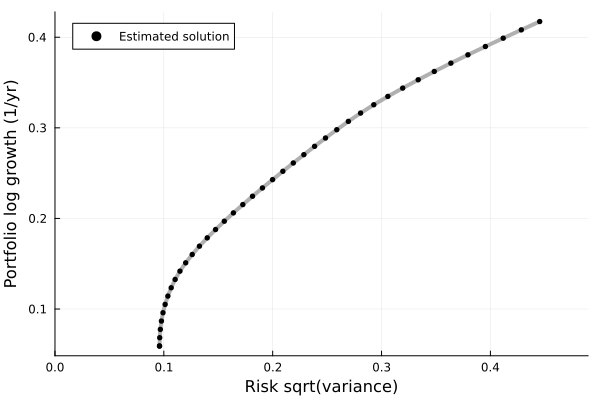

In [42]:
let
    plot(efficient_frontier, lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio log growth (1/yr)", fontsize=18, label="", c=:gray69, 
        xlim=(0.0, 1.1*maximum(efficient_frontier).first))
    scatter!(efficient_frontier, label="Estimated solution", c=:black, ms=3)
end

## Task 3: Compute Optimal allocation with risky and risk-free assets
The Minimum-Variance (Markowitz) portfolio allocation problem for a portfolio composed of risk-free and risky assets $\mathcal{P}$ 
minimizes the variance of the portfolio $\sigma_{\mathcal{P}}^2$ 
subject to a minimal required return and non-negativity constraints: 

\begin{eqnarray*}
\text{minimize}~\sigma_{\mathcal{P}}^2 &=& \sum_{i\in\mathcal{P}}\sum_{j\in\mathcal{P}}\omega_{i}\omega_{j}
\text{cov}\left(r_{i},r_{j}\right) \\
\text{subject to}~\mathbb{E}(r_{\mathcal{P}})& = & \left(\omega_{f}r_{f}+\sum_{i\in\mathcal{P}}\omega_{i}\cdot\mathbb{E}(r_{i})\right)\geq{R^{*}}\\
\omega_{f}+\sum_{i\in\mathcal{P}}\omega_{i} & = & 1 \\
\text{and}~\omega_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray*}

The terms $\omega_{i}\geq{0}$ denote the fraction of risky asset $i\in\mathcal{P}$, 
the quantity $\omega_{f}$ denotes the fraction of risk-free assets in the portfolio, 
$r_{f}$ denotes the risk free rate or return, and $R^{*}$ is the minimum required rate of return 
for overall portfolio $\mathcal{P}$.

* Let's create an instance of the [MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem), and store this in the `problem_risk_free` variable, using the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem},%20NamedTuple}). We pass the covariance array estimated from data and the expected return value, along with bounds, an initial guess, and the risk-free rate to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem},%20NamedTuple}):

In [44]:
problem_risk_free = build(MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem, (
    Σ = Σ̂,
    μ = μ̂,
    bounds = bounds,
    initial = wₒ,
    risk_free_rate = risk_free_rate,
    R = 0.0
));

Iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level in the presence of a risk-free asset using a `for-loop.` In particular, for each pass through the loop, we:
* Update the `problem_risk_free` variable with the minimum desired reward. We then pass the updated `problem_risk_free` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem}) is stored in the `solution_risk_free` dictionary. 
* We check the solution's `status.` If the status indicates an optimal solution was found, we store the solution in the `capital_allocation_line` dictionary.
* Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [46]:
capital_allocation_line = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_free.R = minimum_desired_reward_array[i];

    try
        # compute -
        solution_risk_free = solve(problem_risk_free)

        # check: did this converge?
        status_flag = solution_risk_free["status"];    
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution_risk_free["objective_value"]);
            value = solution_risk_free["reward"];
            capital_allocation_line[key] = value;
        end
    catch err
        # Uncomment to see which R's failed ...
        # println("Failed: desired R = $(problem_risk_free.R). Infeasible");
    end
end
capital_allocation_line;

### TODO: Visualize the capital allocation line and the efficient frontier for a collection of risky-free and risky assets
`Unhide` the code block below to see how we plotted the efficient frontier, i.e., the [minimum-variance solution](https://en.wikipedia.org/wiki/Modern_portfolio_theory) for the collection of equities and the [capital allocation line](https://en.wikipedia.org/wiki/Capital_allocation_line#:~:text=Capital%20allocation%20line%20(CAL)%20is,%2Dto%2Dvariability%20ratio%22.). In the presence of risk-free and risky assets, the optimal portfolio lies along the [capital allocation line](https://en.wikipedia.org/wiki/Capital_allocation_line#:~:text=Capital%20allocation%20line%20(CAL)%20is,%2Dto%2Dvariability%20ratio%22.).
* The [capital allocation line](https://en.wikipedia.org/wiki/Capital_allocation_line#:~:text=Capital%20allocation%20line%20(CAL)%20is,%2Dto%2Dvariability%20ratio%22.) intersects the `y-axis` at the risk-free rate. As we move up the [capital allocation line](https://en.wikipedia.org/wiki/Capital_allocation_line#:~:text=Capital%20allocation%20line%20(CAL)%20is,%2Dto%2Dvariability%20ratio%22.), it intersect the efficient frontier at the [tangent portfolio](https://en.wikipedia.org/wiki/Modern_portfolio_theory). In the tangent portfolio, all of your budget is invested in risky assets. On the other hand, at the risk-free rate all of your budget is invested in risk-free instruments, e.g., Treasury securities.

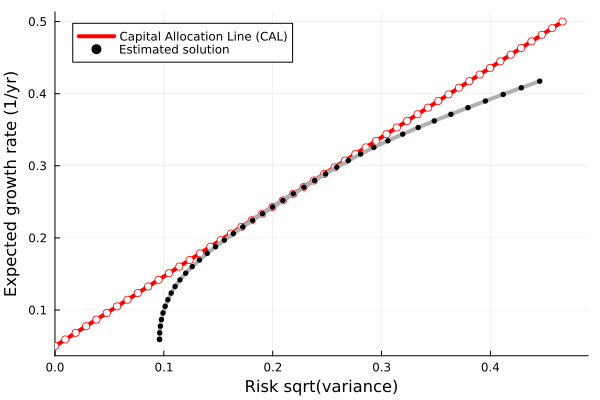

In [48]:
let
    plot(capital_allocation_line, lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Expected growth rate (1/yr)", fontsize=18, c=:red, 
        xlim=(0.0, 1.1*maximum(capital_allocation_line).first), label="Capital Allocation Line (CAL)")
    scatter!(capital_allocation_line, label="", msc=:red, mc=:white)
    plot!(efficient_frontier, lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Expected growth rate (1/yr)", fontsize=18, label="", c=:gray69, 
        xlim=(0.0, 1.1*maximum(efficient_frontier).first))
    scatter!(efficient_frontier, label="Estimated solution", c=:black, ms=3)
end

### Where is the tangent portfolio?
The tangent portfolio is the point on the capital allocation line where the fraction of assets invested in the pool of risky assets is 1, meaning all of our investment budget is invested in risky assets, such as equities. It's called the tangent portfolio because, at this point, the capital allocation line is tangent to the efficient frontier. Let's estimate the expected return of the tangent portfolio by trial and error.

In [50]:
problem_risk_free.R = 0.2512 # change this until fraction of risku assets = 1
allocation_sum_constraint = solve(problem_risk_free) |> x-> x["argmax"] |> x-> sum(x);
println("fraction in risk-free assets: $(1-allocation_sum_constraint), fraction in risky assets: $(allocation_sum_constraint)")

fraction in risk-free assets: 1.8529334377515028e-5, fraction in risky assets: 0.9999814706656225


Next, let's resolve the investment problem for the weights at the tangent portfolio:

In [52]:
tangent_portfolio_solution = nothing;
try 
    tangent_portfolio_solution = solve(problem_risk_free)
catch err
    println("Hmm. that didn't work like we expected ....");
end

Dict{String, Any} with 4 entries:
  "argmax"          => [0.184969, -9.33539e-9, 0.35182, 0.0358492, -8.74686e-9,…
  "reward"          => 0.2512
  "status"          => LOCALLY_SOLVED
  "objective_value" => 0.043459

#### What's in the tangent portfolio?
`Unhide` the code block below to see how we build a table holding the portfolio weights for the `tangent_portfolio_solution` portfolio:

In [54]:
let
    ω = tangent_portfolio_solution["argmax"];
    table_df = DataFrame();
    for i ∈ eachindex(my_low_correlation_ticker_array)
        ticker = my_low_correlation_ticker_array[i];
        ωᵢ = ω[i];
        row_data = (
            ticker = ticker,
            ω = round(ωᵢ, digits=4)
        );
        push!(table_df,row_data)
    end
    
    # compute the total -
    total = table_df[:,:ω] |> sum
    last_row = (
        ticker = "total",
        ω = total
    )
    push!(table_df,last_row)
    table_df
end

Row,ticker,ω
,String,Float64
1,AAPL,0.185
2,UNG,-0.0
3,MSFT,0.3518
4,KR,0.0358
5,INTC,-0.0
6,CPB,-0.0
7,MU,-0.0
8,GIS,-0.0
9,AMD,0.227


## Task 4: Which point should we select on the capital allocation line?
In the presence of a risk-free asset, the investor must select the fraction of funds to put into the risk-free investment versus the collection of risky assets in the tangent portfolio. Thus, unlike selecting any portfolio along the efficient frontier, in the case of risky and risk-free portfolios, the investor chooses a point along the line that connects the risk-free asset to the tangent portfolio, i.e., the capital allocation line (CAL). 

* __Hmmmm__: But how do we decide what fraction to use? A _rational_ investor will maximize an investment's utility (satisfaction) subject to their $\textit{risk-aversion}$, which we represent as the parameter $A$.

### TODO: Compute the fraction of risky assets as a function of the risk-aversion parameter $A$
An example utility function describing the tradeoff between a risk-free asset and the tangent portfolio $\mathcal{T}$ is given by:
$$
\begin{equation*}
U(\theta) = r_{f} + \theta\cdot(\mathbb{E}\left(r_{\mathcal{T}}\right) - r_{f}) - \frac{A}{2}\cdot\theta^{2}\cdot\sigma_{\mathcal{T}}^{2}
\end{equation*}
$$
where $\theta$ is the fraction of the investor's wealth invested in the tangent portfolio $\mathcal{T}$, $r_{f}$ is the risk-free rate, 
$\sigma^{2}_{\mathcal{T}}$ is the variance of the return of the tangent portfolio, and $A>0$ is the investor's risk-aversion parameter.
Values of $\theta = 0$ represent a portfolio of only risk-free assets, while $\theta=1$ represents all assets invested in the tangent portfolio. Differentiating $U(\theta)$ with respect to $\theta$ and setting the result equal to zero yields the optimal $\theta^{\star}$:
$$
\begin{equation}
\theta^{\star} = \frac{\mathbb{E}\left(r_{\mathcal{T}}\right) - r_{f}}{A\cdot\sigma_{\mathcal{T}}^{2}}
\end{equation}
$$
As $A\rightarrow\infty$, the investor becomes more `risk-averse,` i.e., they are _less likely_ to tolerate uncertainty in the investment return. On the other hand, $A\rightarrow0$, the investor becomes more `risk-seeking,` i.e., they are _more comfortable_ with uncertainty in the investment return.

Set some values for the risk-aversion parameter $A\in\left(0,\infty\right)$ and look at what this does to our choices:

In [90]:
A = 5; # set a value for A (A big => risk averse)

# -- Below here, we compute the optimal θ̂ -------------------------------------- #
variance = tangent_portfolio_solution["objective_value"]
θ̂ = (problem_risk_free.R - risk_free_rate)/(A*variance);
risk_value = θ̂*sqrt(variance);
reward_value = θ̂*(problem_risk_free.R)+(1-θ̂)*problem_risk_free.risk_free_rate;
println("θ̂ = $(θ̂), reward = $(reward_value), risk (σ) = $(risk_value)")
# ------------------------------------------------------------------------------ #

θ̂ = 0.9259299299134263, reward = 0.23629710189858136, risk (σ) = 0.19302699391462397


## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.